In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Binomial

### Create data

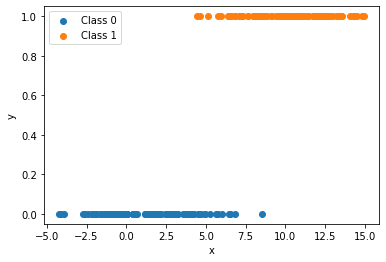

In [ ]:
n = 100

c0 = np.random.normal(loc=1, scale=2.5, size=(1, n))
c1 = np.random.normal(loc=10, scale=2.5, size=(1, n))

plt.scatter(c0, np.zeros_like(c0), label='Class 0')
plt.scatter(c1, np.ones_like(c1), label='Class 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Fit model

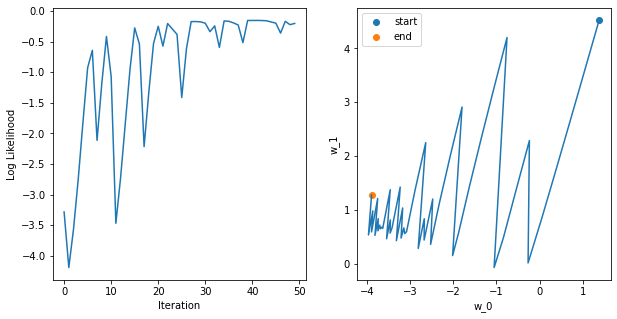

In [ ]:
x = np.concatenate((
    np.ones((1, 2 * n)),  # (1, 2n)
    np.concatenate((c0, c1), axis=1)  # (1, 2n)
), axis=0)  # (2, 2n)

y = np.concatenate((
    np.zeros((1, n)),
    np.ones((1, n))
), axis=1)  # (1, 2 * n)

w = np.random.randn(2, 1)

def sigmoid(a):
  return 1 / (1 + np.exp(-a))

ws = []
ll_avgs = []
eps = 1e-9  # avoid log(near 0) warnings
for i in range(50):
    a = w.T @ x  # (1, 2n)
    ll_avg = (  # (1, 2n) @ (2n, 1) = (1, 1)
        y @ np.log(sigmoid(a) + eps).T +
        (1 - y) @ np.log(1 - sigmoid(a) + eps).T
    ) / (2 * n)
    g = np.mean((y - sigmoid(a)) * x, axis=1, keepdims=True)  # (2, 1)
    w = w + g  # (2, 1)
    ws.append(w)
    ll_avgs.append(ll_avg.item())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ll_avgs)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')

plt.subplot(1, 2, 2)
ws = np.array(ws).reshape(-1, 2).T
plt.plot(*ws)
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.scatter(*ws[:, :1], label='start')
plt.scatter(*ws[:, -1:], label='end')
plt.legend()
plt.show()

### Evaluate

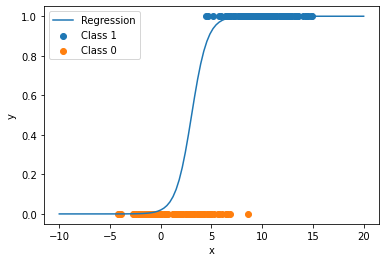

Probability that x=5 belongs to class 1: 0.92


In [ ]:
x_ = np.stack((
    np.ones(100),
    np.linspace(-10, 20, 100)
))  # (2, 100)
y_ = sigmoid(w.T @ x_).reshape(-1)  # (1, 2) @ (2, 100) = (1, 100)

plt.plot(x_[1], y_, label='Regression')
plt.scatter(c1, np.ones_like(c1), label='Class 1')
plt.scatter(c0, np.zeros_like(c0), label='Class 0')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

print(f'Probability that x=5 belongs to class 1: {sigmoid(w.T @ [1,5])[0]:.2f}')

# Multinomial (softmax)

### Create data

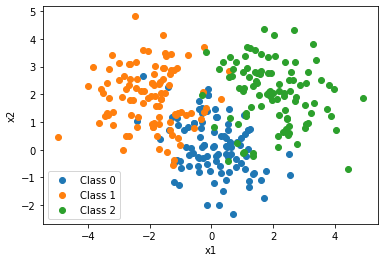

In [ ]:
c0 = np.random.multivariate_normal([0, 0], np.eye(2), n).T  # (2, 100)
c1 = np.random.multivariate_normal([-2, 2], np.eye(2), n).T
c2 = np.random.multivariate_normal([2, 2], np.eye(2), n).T

plt.scatter(*c0, label='Class 0')
plt.scatter(*c1, label='Class 1')
plt.scatter(*c2, label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

### Fit model

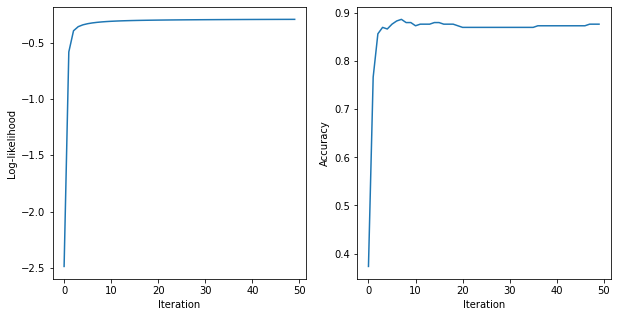

In [ ]:
# Stack and add a 1 for the bias

x = np.concatenate((
    np.ones((1, 3 * n)),  # (1, 300)
    np.concatenate((c0, c1, c2), axis=1)  # (2, 300)
), axis=0)  # (3, 300)

# Use one-hot encoding for the labels
y = np.zeros((3, 3 * n))
y[0, :n] = 1
y[1, n:2 * n] = 1
y[2, 2 * n:] = 1

# Initialize parameters
w = np.random.randn(3, 3)

def softmax(a):
  return np.exp(a) / np.sum(np.exp(a), axis=0, keepdims=True)

ll_avgs = []
accuracies = []

# Run the optimization
for i in range(50):
    y_hat = softmax(w.T @ x)  # (3, 300)

    ll_avg = np.sum(y * np.log(y_hat)) / (3 * n)
    accuracy = np.mean(np.argmax(y_hat, axis=0) == np.argmax(y, axis=0))

    ll_avgs.append(ll_avg)
    accuracies.append(accuracy)

    w = w + x @ (y - y_hat).T / (3 * n)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ll_avgs)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

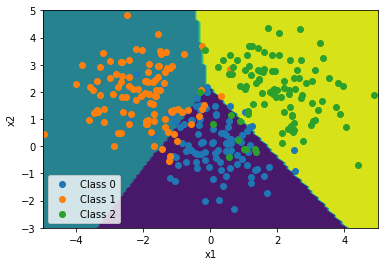

In [ ]:
m = 100
x1, x2 = np.meshgrid(np.linspace(-5, 5, m), np.linspace(-3, 5, m))
x_ = np.concatenate((
    np.ones((1, m * m)),
    x1.reshape(1, -1),
    x2.reshape(1, -1)
), axis=0)  # (3, m * m)

y_ = softmax(w.T @ x_)  # (3, m * m)
winners = np.argmax(y_, axis=0)  # (m * m,)

plt.contourf(x1, x2, winners.reshape((m, m)))

plt.scatter(*c0, label='Class 0')
plt.scatter(*c1, label='Class 1')
plt.scatter(*c2, label='Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim([-5, 5])
plt.ylim([-3, 5])
plt.legend()
plt.show()

# Now MNIST

In [4]:
# torch
import torch
from torchvision import datasets

# sklearn
import sklearn.preprocessing
from tqdm.notebook import tqdm

mnist_train_dataset = datasets.MNIST('', train=True, download=True)
mnist_test_dataset = datasets.MNIST('', train=False, download=True)

x_train = np.array(mnist_train_dataset.data)
y_train = np.array(mnist_train_dataset.targets)

x_test = np.array(mnist_test_dataset.data)
y_test = np.array(mnist_test_dataset.targets)

In [5]:
# One-hot encode labels
y_train = sklearn.preprocessing.label_binarize(y_train, classes=range(10))
y_test = sklearn.preprocessing.label_binarize(y_test, classes=range(10))

# Normalize images
x_train, x_test = x_train / 255 - 0.5, x_test / 255 - 0.5

# Vectorize
d_data = np.prod(x_train.shape[1:])
x_train = x_train.reshape((-1, d_data))
x_test = x_test.reshape((-1, d_data))

# Store images/labels in columns
x_train, y_train, x_test, y_test = x_train.T, y_train.T, x_test.T, y_test.T

# Add bias term
x_train = np.concatenate((np.ones((1, 60000)), x_train), axis=0)
x_test = np.concatenate((np.ones((1, 10000)), x_test), axis=0)
d_data += 1

# Initialize parameters
w = np.random.randn(d_data, 10) * 1e-2

In [8]:
# stats
ll_avgs = []
accuracies = []

# optimization loop
for i in tqdm(range(200)):
    y_hat = softmax(w.T @ x_train)
    ll_avg = np.sum(y_train * np.log(y_hat + eps)) / y_train.shape[1]
    ll_avgs.append(ll_avg)
    w = w + 0.2 * x_train @ (y_train - y_hat).T / y_train.shape[1]

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

Classification rate, train: 0.8908
Classification rate, test: 0.8974


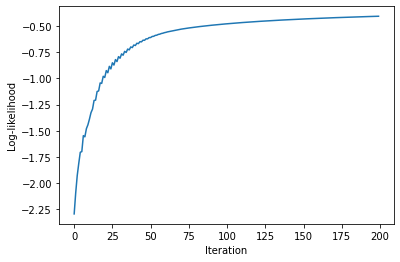

In [ ]:
# evaluation
plt.plot(ll_avgs)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')

yhat = softmax(w.T @ x_train)
print('Classification rate, train:', np.mean(np.argmax(yhat, 0) == np.argmax(y_train, 0)))

yhat = softmax(w.T @ x_test)
print('Classification rate, test:', np.mean(np.argmax(yhat, 0) == np.argmax(y_test, 0)))

Around 90 % accuracy, which is not as good as the knn classifier we 'trained' last week,
but notice that at inference time, the input image is simply fed  through the network,
and thus inference time-complexity is independent of the size of the training dataset.
A huge improvement to comparing the input image with all training images.